<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/projects/team_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# uncomment the 2 lines below if you had error
#!pip install control
#!pip install slycot
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import slycot # to MIMO systems
#from scipy.integrate import odeint

     |████████████████████████████████| 348kB 6.6MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=21914ba32d1d34079c5a763955b1420c8008dab42152fe94474043c25dbdd354
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [42]:
def berg_update(t, x, u, params={}):
  """Insulin dynamics based on Bergman minimal model.

    Parameters
    ----------
    x : array
         System state: G, the deviation of the blood glucose concentration from
                       basal levels measured in mg dL−1
                       I, the deviation of the blood insulin concentration from 
                       basal levels measured in mU L−1
                       X, a proportionality variable that describes the insulin 
                       concentration in a remote compartment measured in mU L−1
    u : array
         System input: U, the insulin input from an external source and into the
                       bloodstream, measured in mU min−1
                       D, a disturbance variable representing the intake of 
                       glucose from external sources, typically food, measured 
                       in mg dL−1min−1

    Returns
    -------
    y : array
        The time derivatives of G, I and X

    """

  # Set up the system parameters
  Gb = params.get('Gb', 81.)      # mg/dL
  Ib = params.get('Ib', 15.)      # mU/L
  P1 = params.get('P1', 0.0287)   # 1/min
  P1_s = params.get('P1_s', 0.02) # 1/min
  P2 = params.get('P2', 0.0287)   # 1/min 
  P3 = params.get('P3', 5.035e-5) # L/mU/min^2  
  n = params.get('n', 5/54)       # 1/min  
  V1 = params.get('V1', 12)       # L  

  # Define variables for patient state and inputs
  G = x[0]                           # blood glucose concentration
  I = x[1]                           # blood insulin concentration
  X = x[2]                           # insulin concentration in a remote 
                                     # compartment
  U = u[0]                           # insulin input
  D = u[1]                           # intake of glucose

  # Define the ODEs
  dGdt = -P1*G - X*(G+Gb) + D
  dIdt = -n*(I+Ib) + U/V1
  dXdt = -P2*X + P3*I

  return [dGdt, dIdt, dXdt]

In [43]:
# Obtain the transfer functions of the input/output system for the bergman minimal model
bergman = ct.NonlinearIOSystem(
    berg_update, None, name='bergman',
    inputs = ('U', 'D'), outputs = ('G', 'I', 'X'), states=('G', 'I', 'X'))

bergman_linearized = bergman.linearize(x0=[0, 0, 0], u0=[0, 0])

bergman_tf = ct.ss2tf(bergman_linearized)

bergman_tf

TransferFunction([[array([-0.00033986]), array([1.        , 0.12129259, 0.00265741])], [array([0.08333333, 0.        , 0.        ]), array([0.])], [array([4.19583333e-06, 0.00000000e+00]), array([0.])]], [[array([1.00000000e+00, 1.49992592e-01, 6.13850481e-03, 7.62675925e-05]), array([1.00000000e+00, 1.49992592e-01, 6.13850481e-03, 7.62675925e-05])], [array([1.        , 0.09259259, 0.        , 0.        ]), array([1.])], [array([1.        , 0.12129259, 0.00265741, 0.        ]), array([1.])]])

In [49]:
G_p = bergman_tf[0,0]
G_p

TransferFunction(array([-0.00033986]), array([1.00000000e+00, 1.49992592e-01, 6.13850481e-03, 7.62675925e-05]))

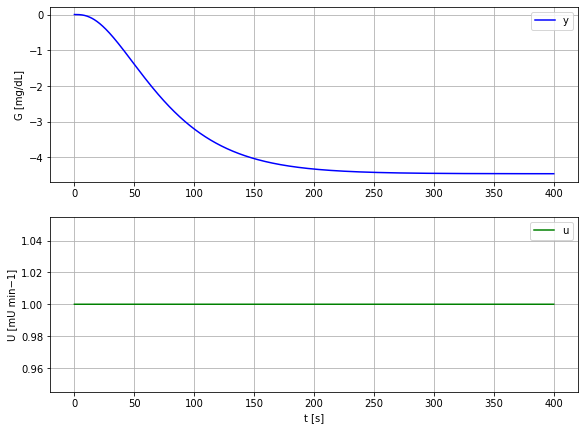

In [48]:
# Defining time and input and initial values
T0 = 0
T1 = 400
dt = 0.01
nt = int (T1/dt) + 1 # Number of points of sim time
T = np.linspace(T0, T1, nt)
u = np.ones(nt)

# Simulation
Ga = 1
Gm = 1
T, yout = ct.step_response(Ga*Gp*Gm, T)

# Plotting
plt.close ('all')
fig_width_cm = 24
fig_height_cm = 18
plt.figure(1, figsize=(fig_width_cm /2.54 , fig_height_cm /2.54))
plt.subplot(2, 1, 1)
plt.plot(T, yout, 'blue')
plt.ylabel('G [mg/dL]')
plt.grid()
plt.legend(labels =('y',))
plt.subplot(2, 1, 2)
plt.plot(T, u, 'green')
plt.ylabel('U [mU min−1]')
plt.xlabel('t [s]')
plt.grid()
plt.legend(labels =('u', ))